#  Lunar Lander with SARSA($\lambda$) :

Author: Nirav Lad

This notebook implements [Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) as available through [Farama Foundation Gymnasium](https://gymnasium.farama.org/).  The algorithm utilized is SARSA($\lambda$) as discussed in [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html) by Sutton and Barto.

## Import libraries

In [1]:
try:
    import google.colab
    from IPython.display import clear_output
    !apt-get install swig
    !pip install swig
    !pip install gymnasium[box2d]
    !pip install moviepy==2.2.1
    clear_output(wait=True)
except ImportError:
    pass

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import gymnasium as gym

from typing import List, Tuple, Union, Callable
from numpy.typing import NDArray
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import seaborn as sns

from gymnasium.wrappers import RecordVideo
from moviepy import VideoFileClip, TextClip, CompositeVideoClip, concatenate_videoclips
from IPython.display import Video
import os
import shutil

## Define parameters

### Enviroment variables

In [3]:
ENV_NAME = 'LunarLander-v3'

In [4]:
env = gym.make(ENV_NAME)
SLOW = env.observation_space.low
SHIGH = env.observation_space.high
SRANGE = SHIGH - SLOW
cardS = len( env.observation_space.low )
A = np.arange( env.action_space.n )
cardA = len(A)
env.close()
num_best_policies = 10

### Hyperparameters

In [5]:
γ = 0.999
λ = 0
Δ = 1e-9
lr = (0.1, 0.1)

## Functions

### Helper Functions

In [6]:
def calculate_mean_hw( d: Union[List[np.float32] | NDArray[np.float32]], 
                       ci:int = 0.95 ) -> Tuple[np.float32, np.float32]:
    d = np.array( d )
    n = np.size( d )
    std_error = np.std( d, ddof=1 ) / np.sqrt(n)
    t_critical = stats.t.ppf( 1 - ( 1 - ci ) / 2, n - 1 )
    mean = np.mean( d ) 
    halfwidth = t_critical * std_error
    return( mean, halfwidth )

In [7]:
def record_policy( w:NDArray[np.float32], 
                   φ:Callable[[NDArray[np.float32], int],int],
                   title:str, 
                   M:int = 10, 
                   seed:int = 2025,
                   enable_wind = False ) -> str:

    import warnings
    warnings.filterwarnings("ignore", message=".*Overwriting existing videos.*")
    os.makedirs("videos", exist_ok=True)
    env = gym.make(ENV_NAME, render_mode="rgb_array", enable_wind=enable_wind)
    env = RecordVideo(env, video_folder="videos", episode_trigger=lambda ep: True)

    G = []

    for m in np.arange(M):

        Gm = 0
        s,_ = env.reset( seed = int( seed * 1e2 + m * 3e4 ) )
        terminated = False
        truncated = False
        while not( terminated or truncated ):
            a = π( s, w, φ )
            sP, r, terminated, truncated, _ = env.step( a )
            s = sP
            Gm += r
        
        G.append( Gm )

    μ, δ = calculate_mean_hw( G )
    score = μ - δ

    env.close()

    video_files = sorted([f for f in os.listdir("videos") if f.endswith(".mp4")])
    annotated_clips = []
    for i, vf in enumerate(video_files):
        clip = VideoFileClip(f"videos/{vf}", )
        
        txt = TextClip( text=f"{title}\nEP {i+1:2d} Reward: {G[i]:0.1f}\nScore: {score:0.1f} ({μ:0.1f} ± {δ:0.1f})", 
                        font_size=14, 
                        color='white', 
                        method='caption',
                        vertical_align='left', horizontal_align='top',
                        size = (clip.w, 60) )
        txt = txt.with_duration(clip.duration)
        
        annotated_clip = CompositeVideoClip([clip, txt])
        annotated_clips.append(annotated_clip)

    final_clip = concatenate_videoclips(annotated_clips )

    fname = f"best_policy_({score:0.1f}).mp4"
    final_clip.write_videofile(fname)

    shutil.rmtree("videos")

    return( fname )

### Poilicy function ($\pi$)

$\pi(s) =\arg \max_{a \in \mathcal{A}} \Phi(s,a)^{\intercal} w$

In [8]:
def π( state:NDArray[np.float32], 
       w:NDArray[np.float32], 
       φ:Callable[[NDArray[np.float32], int], int] ) -> int:
    
    return( np.argmax([np.dot( φ(state, a), w ) for a in A]) )

### TD Learning rate/step size

The learning rate at episode $n$ with initial learnign rate $\alpha_a$ and learning rate decay $\alpha_b$ is defined as $\alpha_n =  a_{a}\left( \frac{1}{(1 + n)^{\alpha_{b}}} \right)$

In [9]:
def α( n:int ) -> float:
    α_init, α_decay = lr
    return( α_init / (n + 1)**α_decay )

### Evaluate policy

In [10]:
def evaluate_policy( w:NDArray[np.float32], 
                     φ:Callable[[NDArray[np.float32], int], int], 
                     num_evaluations:int = 10,
                     seed:int = 42,
                     enable_wind:bool = False ) -> Tuple[np.float32, np.float32]:
    
    env = gym.make(ENV_NAME, enable_wind=enable_wind)
    
    G = []

    for n in np.arange(num_evaluations):
        terminated = False
        truncated = False
        Gm = 0
        s,_ = env.reset( seed = int( seed * 1e2 + n * 3e4 ) )
        while not( terminated or truncated ):
            a = π( s, w, φ )
            sP, r, terminated, truncated,_ = env.step(a)
            s = sP
            Gm += r

        G.append(Gm)

    env.close()
    mean, hw = calculate_mean_hw(G)
    return( mean, hw )


### **SARSA**($\lambda$)

Algorithm taken from [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html) by Sutton and Barto.

<b>Inputs</b>:
- $\pi$: Policy whose value function is sought
-  function $\hat{v}:S \times \mathbb{R}^d \rightarrow \mathbb{R}$

<b>Parameters</b>
- step size $\alpha > 0$, trace decay rate $\lambda \in [0,1]$

<b>algorithm</b>:<br>
01: Initialize value-function weights $\mathbf{w}$ (e.g. $\mathbf{w} = 0$)<br>
02: Loop for each episode:<br>
03: &nbsp;&nbsp;&nbsp;&nbsp;Initailize $S$<br>
04: &nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{z} \gets \mathbf{0}$<br>
05: &nbsp;&nbsp;&nbsp;&nbsp;Loop for each step of episode:<br>
06: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Choose $A \sim \pi(\cdot | S)$<br>
07: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Take action $A$, observe $R, S'$<br>
08: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{z} \gets \gamma \lambda \mathbf{z} + \nabla\hat{v}(S,\mathbf{w})$<br>
09: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\delta \gets R + \gamma \hat{v}(S',\mathbf{w}) - \hat{v}(S,\mathbf{w})$<br>
10: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\mathbf{w} \gets \mathbf{w} + \alpha \delta \mathbf{z}$<br>
11: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$S \gets S'$<br>
12: &nbsp;&nbsp;&nbsp;&nbsp;Until $S'$ is terminal


In [11]:
def SARSAλ( w:NDArray[np.float32], 
                φ:Callable[ [NDArray[np.float32], int], int ], 
                M:int = 500, 
                seed:int = 1982, 
                enable_wind:bool=False ) -> NDArray[np.float32]:

    env = gym.make(ENV_NAME, enable_wind=enable_wind)

    d = []
    
    wP = w

    for m in tqdm( np.arange(M) ):

        z = np.zeros_like( w )

        terminated = False
        truncated = False
        s,_ = env.reset(seed=int(m * 1e5 + seed * 2e3))
        np.random.seed(seed=int(m * 1e5 + seed * 2e3) )
        
        Qold = 0
        while not(terminated or truncated):
            
            a = π( s, w, φ )
                
            sP, r, terminated, truncated, _ = env.step(a)
            
            aP = π( sP, w, φ )

         
            Q = np.dot( w, φ( s, a ) )
            Qp = np.dot( w, φ( sP, aP ) ) * ( 1 - terminated )
            
            δ = (r + γ * Qp - Q)

            z = γ * λ * z + (1 - α(m) * γ * λ * np.dot( z, φ( s, a ) ) ) * φ( s, a )


            wP = wP + α(m) *( δ  + Q - Qold )* z - α(m) * (Q - Qold) * φ( s, a ) 
            Qold = Qp
            s = sP
            a = aP
            
        w = wP

        μ, δ = evaluate_policy( w, φ, seed=seed, enable_wind=enable_wind, num_evaluations=10 )
        score = μ - δ 
        d.append({'episode':m, 'score': score, 'mean': μ, 'halfwidth': δ, 'w': w.copy()})
        tqdm.write(f"Episode{m:3d}:\t{score:.2f}\t({μ:3.2f} ± {δ:3.2f})")

    env.close()

    policies = pd.DataFrame( d )

    return( policies )


## Run **SARSA**($\lambda$)

### Feature vectors

In [12]:
def simple(state, action):
    x = np.hstack( ( state ) )
    fv = np.hstack([x * (action == a) for a in A ])
    return( fv )

In [13]:
def interactions(state,action):
    state = state
    px, py, vx, vy, θ, ω, lf, rf = state

    interactions = np.array([px*py, px*vx, px*θ, px*ω, px*lf, px*rf,
                             py*vx, py*vy, py*θ, py*ω, py*lf, py*rf,
                             vx*vy, vx*θ, vx*ω, vx*lf, vx*rf,
                             vy*θ, vy*ω, vy*lf, vy*rf,
                             θ*ω, θ*lf, θ*rf,
                             θ*lf, θ*rf,
                             lf*rf])

    x = np.hstack( ( state, interactions ))
    fv = np.hstack([x * (action == a) for a in A ])
    return( fv )

In [14]:
f = interactions
seed = 1982
k = len( f( np.zeros(cardS), 0 ) )
w = np.zeros( k )
policies = SARSAλ( w, M=500, φ=f, seed=seed, enable_wind=False )

  0%|          | 0/500 [00:00<?, ?it/s]

Episode  0:	-711.64	(-596.17 ± 115.46)
Episode  1:	-640.00	(-549.08 ± 90.92)
Episode  2:	-349.34	(-227.53 ± 121.81)
Episode  3:	-97.33	(-76.65 ± 20.69)
Episode  4:	-113.14	(-85.79 ± 27.35)
Episode  5:	-192.00	(-110.92 ± 81.07)
Episode  6:	-250.26	(-160.45 ± 89.81)
Episode  7:	-501.68	(-403.77 ± 97.91)
Episode  8:	-561.14	(-438.32 ± 122.83)
Episode  9:	-448.02	(-329.79 ± 118.23)
Episode 10:	-125.43	(-45.83 ± 79.60)
Episode 11:	-68.91	(-6.71 ± 62.21)
Episode 12:	-74.53	(14.13 ± 88.67)
Episode 13:	-95.45	(-27.53 ± 67.92)
Episode 14:	0.84	(86.32 ± 85.48)
Episode 15:	-13.57	(15.63 ± 29.20)
Episode 16:	-74.05	(18.70 ± 92.75)
Episode 17:	-3.34	(79.95 ± 83.29)
Episode 18:	-38.80	(74.39 ± 113.19)
Episode 19:	-82.59	(27.99 ± 110.58)
Episode 20:	33.46	(117.45 ± 84.00)
Episode 21:	-123.40	(-92.54 ± 30.85)
Episode 22:	-165.81	(-145.38 ± 20.43)
Episode 23:	-165.83	(-103.39 ± 62.44)
Episode 24:	-176.39	(-73.80 ± 102.59)
Episode 25:	-179.30	(-83.29 ± 96.01)
Episode 26:	-199.63	(-121.77 ± 77.85)
Episod

### Plot learning curve

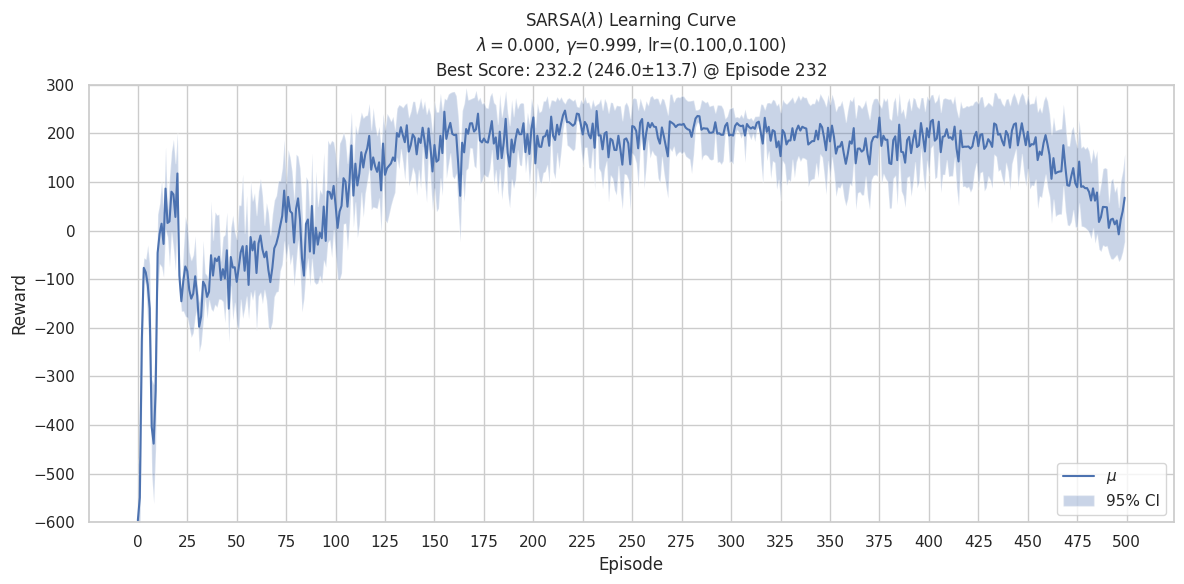

In [15]:
plt.figure(figsize=(12, 6))  
sns.set_theme(style="whitegrid") 
sns.lineplot(data=policies, x='episode', y='mean', label="$\\mu$")
plt.fill_between( policies['episode'],
                  policies['mean'] - policies['halfwidth'],
                  policies['mean'] + policies['halfwidth'],
                  alpha=0.3,
                  label='95% CI')

policies.sort_values(by='score', ascending=False, inplace=True)
p = policies.iloc[0]

plt.title(f"SARSA($\\lambda$) Learning Curve\n" +\
          f"$\\lambda={λ:.3f}$, $\\gamma$={γ:0.3f}, lr=({lr[0]:0.3f},{lr[1]:0.3f})\n" + \
          f"Best Score: {p['score']:.1f} ({p['mean']:.1f}$\\pm${p['halfwidth']:.1f}) @ Episode {p['episode']}" )
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.ylim(-600, 300)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(25))
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig(f"learning_curve.pdf")

plt.show()

### Determine best policy ($w^*$)

In [16]:
best_score = -np.inf
print(f"EVALUATING TOP {num_best_policies} POLICES")
print("\t\tScore\t(μ ± δ)")
for i, p in policies.head(num_best_policies).iterrows():
    μ, δ = evaluate_policy(p['w'], f, num_evaluations=30, seed=1776, enable_wind=False)
    score = μ - δ
    print(f"Episode {i:3d}\t{score:.1f}\t({μ:.1f} ± {δ:.1f})")
    if ( best_score < score ):
        best_score = score
        w_star = p['w']
        m_star = p['episode']

print(f"SUPERLATIVE POLICY:\tEPISODE {m_star}")

EVALUATING TOP 10 POLICES
		Score	(μ ± δ)
Episode 232	142.4	(182.9 ± 40.6)
Episode 216	150.2	(188.2 ± 38.0)
Episode 222	186.9	(214.7 ± 27.8)
Episode 223	136.9	(178.6 ± 41.8)
Episode 283	163.3	(195.0 ± 31.7)
Episode 284	140.6	(174.9 ± 34.3)
Episode 155	82.5	(127.7 ± 45.2)
Episode 317	158.4	(191.2 ± 32.8)
Episode 172	113.7	(153.8 ± 40.1)
Episode 282	148.1	(183.9 ± 35.8)
SUPERLATIVE POLICY:	EPISODE 222


### The superlative policy $w^*$ weights

In [17]:
np.set_printoptions(precision=2)
print(f"w*:")
print( w_star.reshape(-1,4) )

w*:
[[-5.88e+01  4.21e+01 -2.04e+01  2.63e+01]
 [ 5.33e+00 -3.33e+01  4.09e+01  3.41e+01]
 [-1.13e+01 -2.87e+01  3.39e+01  1.77e+01]
 [-1.06e+00  1.20e+00 -9.26e+00 -3.53e+01]
 [-1.36e+01  3.02e+01  6.36e+00  6.04e+00]
 [ 1.22e+01  1.58e+01  2.81e+01 -1.76e+01]
 [-1.82e+01 -2.30e+00  6.84e+00  6.25e+01]
 [ 5.89e+01 -8.89e+01 -5.09e+00  7.64e+00]
 [-5.09e+00  7.64e+00 -1.72e+01 -9.10e-02]
 [ 1.24e+00  3.11e+01  1.42e+01 -1.37e+02]
 [ 5.85e+00  7.28e+00  3.46e+00  2.84e+00]
 [-4.81e+01  4.80e+01  4.58e+01  1.10e+01]
 [ 5.84e+00  6.20e+01 -2.39e+01 -8.98e+01]
 [-1.30e+01 -9.28e-01 -2.05e+00 -2.72e+01]
 [ 7.19e+01  4.70e+01 -1.06e+01  1.75e+00]
 [ 1.25e+02  9.32e+01  4.82e+00  3.83e+00]
 [-1.45e+02 -6.11e+00 -3.35e+00 -6.11e+00]
 [-3.35e+00 -1.64e+01 -3.39e+01 -4.77e+01]
 [-5.53e+00 -1.20e+02  4.43e+01 -1.18e+01]
 [-2.49e+01 -2.97e+01  1.29e+01 -9.35e+01]
 [ 9.63e+01  1.24e+01  7.50e-01 -1.74e+00]
 [ 1.52e+01 -1.04e+02 -4.49e+00  1.59e+01]
 [ 8.71e-01  1.83e+00  2.71e+01  1.67e+02]
 [ 2.17

### View video recording of the best policy

In [18]:
title = f"SARSA, LAMBA={λ:0.3f}, GAMMA={γ:0.3f}, lr=({lr[0]:0.3f},{lr[1]:0.3f})"
video_filename = record_policy( w_star, f, title, enable_wind=False, seed=2031 )
print(f"Done! Video saved to {video_filename}")

MoviePy - Building video best_policy_(220.4).mp4.
MoviePy - Writing video best_policy_(220.4).mp4



MoviePy - Done !
MoviePy - video ready best_policy_(220.4).mp4
Done! Video saved to best_policy_(220.4).mp4


In [19]:
Video(video_filename, embed=True)